In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2)

In [2]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0,
                    3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u

In [3]:
def model(t_u, w, b):
    return w * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
params = torch.tensor([1.0, 0.0], requires_grad=True)  # requires_grad=True activa el rastreo mediante un grafo computacional de los tensores
                                                       # y operaciones resultantes sobre params para luego calcular gradientes (backpropagation)

In [6]:
params.grad is None  # Todos los tensores de PyTorch tienen un atributo .grad, normalmente es None

True

In [7]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()  # Calcula las derivas parciales de loss respecto a sus parametros

params.grad  # Ahora el atributo .grad en params almacena el gradiente de loss

tensor([4517.2969,   82.6000])

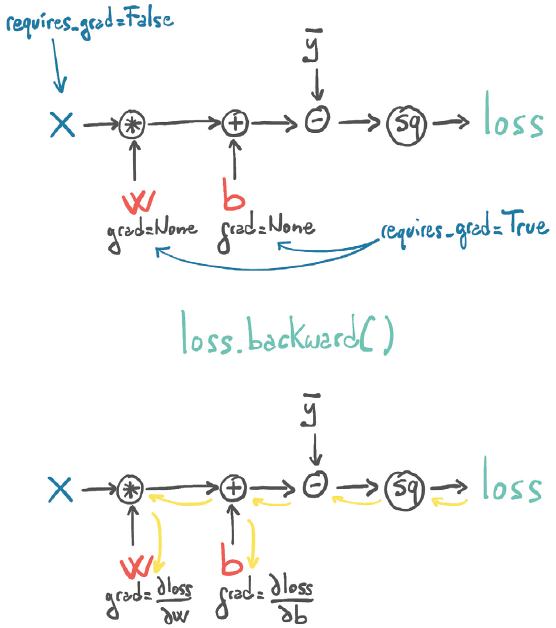

In [8]:
if params.grad is not None:
    params.grad.zero_()

# Acumulación de Gradientes

Llamar a `backward` hará que las derivadas se *acumulen* en los nodos hoja de grafo computacional que crea PyTorch para el seguimiento de los tensores y operaciones sobre ellos. Es necesario poner a cero el gradiente explícitamente después de usarlo para actualizaciones de parámetros.

La acumulación de gradientes es útil en varios casos, especialmente en entrenamiento por mini lotes (mini-batches). En este enfoque, en lugar de actualizar los parámetros después de cada muestra, se acumulan los gradientes en params.grad y se usan para actualizar los parámetros después de procesar cada mini-batch. Después de cada actualización de los parámetros se resetean los gradientes a cero con `.grad_zero_()` y se procesa un nuevo mini-batch.

In [9]:
""" Comentarios:
# <1> Esto se debe hacer antes de loss.backward() para asegurarse de que el gradiente a calcular no se sume
      al que ya este asignado a params.grad (en este caso, ya que se actualiza params en cada iteración).

# <2> Se encapsula la actualización de los parámetros para evitar que Autograd haga seguimiento de la
      misma y genere errores en futuros calculos del gradiente. La actualización se hace con
      params -= .. ya que se quiere modificar el tensor "in-place" y no que se asigne otro.
"""

def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            params.grad.zero_()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad():  # <2>
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [10]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True), # <1>
    t_u = t_un, # <2>
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)